<a href="https://colab.research.google.com/github/Gautam-Chauhan/MAPS-Internship-Code/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using TensorFlow Model Garden



In this notebook, I will fine-tune an object detection model using a pre-trained model from TensorFlow Model Garden.

This is my second attempt - previously I was using TensorFlow Object Detection API, but I encountered many errors, so I decided to switch to this framework instead.

Based on the following TensorFlow tutorial:

https://www.tensorflow.org/tfmodels/vision/object_detection

#### Mount google drive for access to files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Install packages and import libraries

In [2]:
# Uninstall the current numpy version to avoid conflicts
!pip uninstall -y numpy
# Install a numpy version compatible with TensorFlow
!pip install numpy==1.26.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
# Install tf-models-official, ensuring compatibility with the installed numpy and TensorFlow versions
!pip install -U -q "tf-models-official"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.4 MB/s eta 0:00:00
ERROR: pip's dep

In [2]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.19.0


#### Specify file paths to the training/validation/test data

Specify paths to the locations of the datasets and where the model is to be stored and exported:

In [4]:
train_data_input_path = '/content/drive/MyDrive/Object_Detection/Annotations/train.record'
valid_data_input_path = '/content/drive/MyDrive/Object_Detection/Annotations/val.record'
test_data_input_path = '/content/drive/MyDrive/Object_Detection/Annotations/test.record'
model_dir = '/content/drive/MyDrive/Object_Detection/'
export_dir ='/content/drive/MyDrive/Object_Detection/'

Look at a TF Records file to make sure it is configured properly:

In [5]:
def inspect_tfrecord_example_data(tfrecord_path):
  """Reads and prints the keys and data of the first example in a TFRecord file."""
  dataset = tf.data.TFRecordDataset(tfrecord_path)

  # Take the first example
  for serialized_example in dataset.take(1):
    print("--- Inspecting Data of the First Example ---")
    example = tf.train.Example()
    example.ParseFromString(serialized_example.numpy())

    # Print the keys and their data
    print("Features and Data:")
    for key, feature in example.features.feature.items():
      feature_type = feature.WhichOneof("kind")
      print(f"  Key: {key}, Type: {feature_type}")

      # Print the data based on its type
      if feature_type == 'bytes_list':
        # For bytes_list, show the first few bytes and the number of items
        data_list = feature.bytes_list.value
        if key == 'image/encoded':
            print(f"    Data: <encoded image data, size: {len(data_list[0]) if data_list else 0} bytes>")
        elif key == 'image/filename' or key == 'image/format' or key == 'image/source_id' or key == 'image/object/class/text':
             print(f"    Data: {data_list}")
        else:
            print(f"    Data: {data_list}")

      elif feature_type == 'float_list':
        # For float_list, show the values
        print(f"    Data: {feature.float_list.value}")
      elif feature_type == 'int64_list':
        # For int64_list, show the values
        print(f"    Data: {feature.int64_list.value}")
      else:
        print(f"    Data: <Unknown feature type: {feature_type}>")
    print("-" * 20)
    break # Only inspect the first example

# Use the function with your training data path
train_data_input_path = '/content/drive/MyDrive/Object_Detection/Annotations/train.record'
inspect_tfrecord_example_data(train_data_input_path)

--- Inspecting Data of the First Example ---
Features and Data:
  Key: image/width, Type: int64_list
    Data: [3264]
  Key: image/object/bbox/xmax, Type: float_list
    Data: [0.5830269455909729, 0.5765931606292725]
  Key: image/encoded, Type: bytes_list
    Data: <encoded image data, size: 16261743 bytes>
  Key: image/object/class/text, Type: bytes_list
    Data: [b'Trash', b'Trash']
  Key: image/object/bbox/xmin, Type: float_list
    Data: [0.5704656839370728, 0.4629289209842682]
  Key: image/filename, Type: bytes_list
    Data: [b'1001.png']
  Key: image/object/class/label, Type: int64_list
    Data: [1, 1]
  Key: image/object/area, Type: float_list
    Data: [0.00033353056642226875, 0.011607864871621132]
  Key: image/object/bbox/ymin, Type: float_list
    Data: [0.31004902720451355, 0.3014705777168274]
  Key: image/height, Type: int64_list
    Data: [2448]
  Key: image/object/is_crowd, Type: int64_list
    Data: [0, 0]
  Key: image/object/bbox/ymax, Type: float_list
    Data: [0.3

Get the config file and modify it with preferred hyperparameters:

In [6]:
exp_config = exp_factory.get_exp_config('retinanet_resnetfpn_coco')

In [7]:
batch_size = 128
num_classes = 1

HEIGHT, WIDTH = 1024, 1024
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
exp_config.task.freeze_backbone = False
exp_config.task.annotation_file = ''

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size

# Configure some data augmentation options
# Here, we flip images horizontally, but not vertically because we would never see the images upside down in the test dataset
# We also scale images because the objects in the training and test datasets sometimes appear at a range of different scales
exp_config.task.train_data.parser.flip_horizontal = True
exp_config.task.train_data.parser.aug_scale_min = 0.1
exp_config.task.train_data.parser.aug_scale_max = 2.0

# Validation data config.
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

In [8]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 1000
exp_config.trainer.steps_per_loop = 100 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = 100
exp_config.trainer.validation_interval = 100
exp_config.trainer.validation_steps =  100 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

Running on CPU is slow, so only train for a few steps.


In [9]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

Done


Create a new task:

In [10]:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

In [ ]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.keys: {labels.keys()}')

Visualise some of the images and their bounding boxes:

In [11]:
category_index={
    1: {
        'id': 1,
        'name': 'Trash'
       },
}
tf_ex_decoder = TfExampleDecoder()

In [12]:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

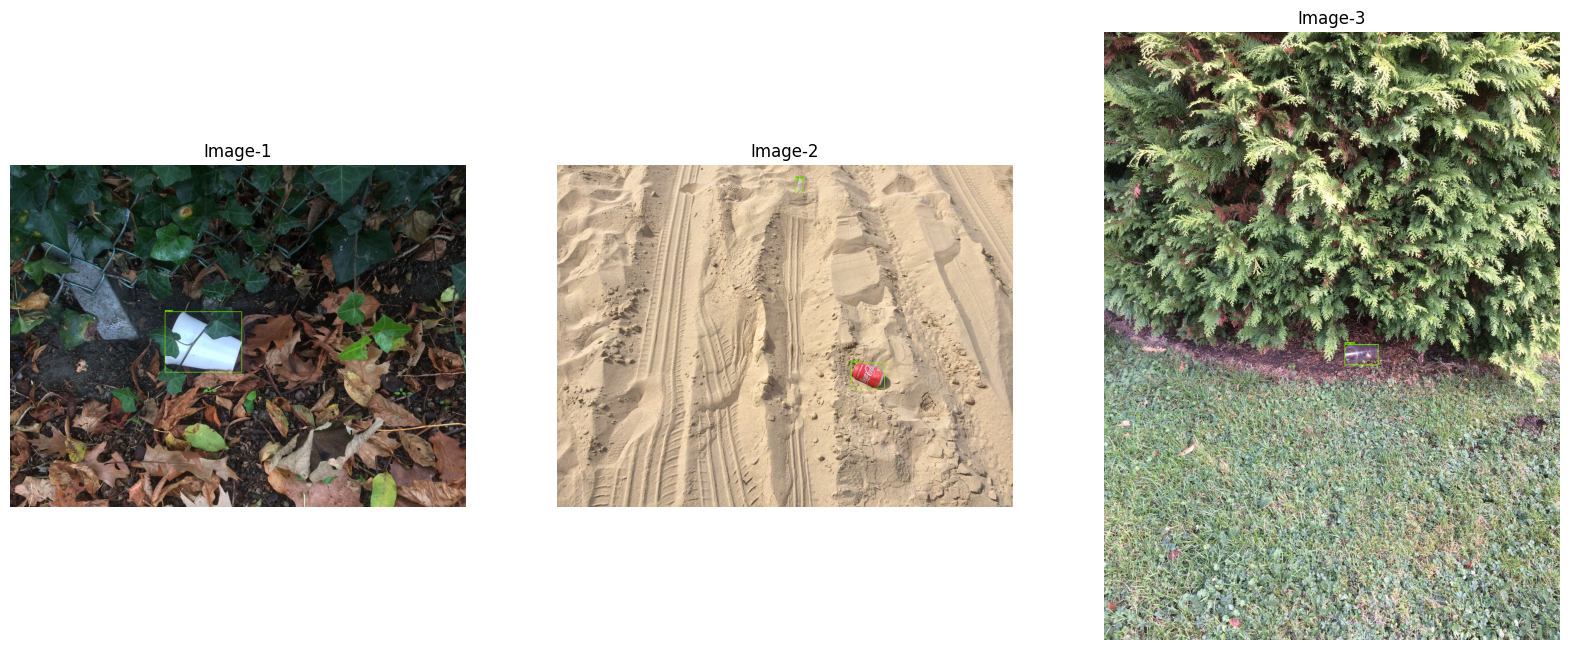

In [13]:
buffer_size = 20
num_of_examples = 3

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

In [ ]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

restoring or initializing model...
train | step:      0 | training until step 100...


In [ ]:
%load_ext tensorboard
%tensorboard --logdir model_dir